# Project2_2

## Data preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import datetime
import numpy as np
import itertools
import seaborn as sns
from scipy import stats
from colorama import Fore, Style

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [2]:
crypto_data_folder = './g-research-crypto-forecasting/'
crypto_data = pd.read_csv(crypto_data_folder + 'train.csv')
asset_data = pd.read_csv(crypto_data_folder + 'asset_details.csv')

In [3]:
def get_initial_asset(asset_id, data = crypto_data):
    df = data[data['Asset_ID'] == asset_id].reset_index(drop = True)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df = df.set_index('timestamp')
    return df

In [4]:
def prep_train_data(data, asset_id):
    train_df = pd.DataFrame(index=data.index)
    for i in range (16):
        train_df['Close(t-'+str(i)+')/Close(t)'] = data.Close.shift(i) / data.Close
        train_df['(Close(t-'+str(i)+')-Open(t-'+str(i)+'))/Close(t)'] = (data.Close.shift(i) - data.Open.shift(i)) / data.Close
        train_df['(High(t-'+str(i)+')-Low(t-'+str(i)+'))/Close(t)'] = (data.High.shift(i) - data.Low.shift(i)) / data.Close
        train_df['Volume(t-'+str(i)+')/Volume(t)'] = data.Volume.shift(i) / data.Volume
        train_df['VWAP(t-'+str(i)+')/VWAP(t)'] = data.VWAP.shift(i) / data.VWAP
        train_df['VWAP(t-'+str(i)+')/Close(t)'] = data.VWAP.shift(i) / data.Close
    train_df['Target'] = (data.Close.shift(-15) - data.Close) / data.Close
    train_df['Target_new'] = np.log(data.Close.shift(-15) / data.Close)
    train_df['Target_2'] = data.Close.shift(-15)/data.Close.rolling('1H').mean() - 1
    w = ['1H', '3H', '6H', '9H', '12H', '24H']
    for i in w:
        train_df['mean(VWAP('+i+'))/Close(t)'] = data.VWAP.rolling(i).mean() / data.Close
        train_df['mean(Count('+i+'))/Count(t)'] = data.Count.rolling(i).mean() / data.Count
        train_df['mean(Volume('+i+'))/Volume(t)'] = data.Volume.rolling(i).mean() / data.Volume
        train_df['min(Close('+i+'))/Close(t)'] = data.Close.rolling(i).min() / data.Close
        train_df['max(Close('+i+'))/Close(t)'] = data.Close.rolling(i).max() / data.Close
        train_df['std(VWAP('+i+'))/Close(t)'] = data.VWAP.rolling(i).std() / data.Close
        train_df['std(Count('+i+'))/Count(t)'] = data.Count.rolling(i).std() / data.Count
        train_df['std(Volume('+i+'))/Volume(t)'] = data.Volume.rolling(i).std() / data.Volume
        train_df['std(Close('+i+'))/Close(t)'] = data.Close.rolling(i).std() / data.Close
    w1 = ['15min', '30min', '1H', '3H']
    for i in w1:
        train_df['mean(VWAP('+i+'))/mean(VWAP(24H))'] = data.VWAP.rolling(i).mean() / data.VWAP.rolling('24H').mean()
        train_df['mean(Count('+i+'))/mean(Count(24H))'] = data.Count.rolling(i).mean() / data.Count.rolling('24H').mean()
        train_df['mean(Volume('+i+'))/mean(Volume(24H))'] = data.Volume.rolling(i).mean() / data.Volume.rolling('24H').mean()
        train_df['mean(High('+i+'))/mean(High(24H))'] = data.High.rolling(i).mean() / data.High.rolling('24H').mean()
        train_df['mean(Low('+i+'))/mean(Low(24H))'] = data.Low.rolling(i).mean() / data.Low.rolling('24H').mean()
        train_df['mean(Close('+i+'))/mean(Close(24H))'] = data.Close.rolling(i).mean() / data.Close.rolling('24H').mean()
        train_df['mean(Low('+i+'))/mean(VWAP(24H))'] = data.Low.rolling(i).mean() / data.VWAP.rolling('24H').mean()
        train_df['mean(High('+i+'))/mean(VWAP(24H))'] = data.High.rolling(i).mean() / data.VWAP.rolling('24H').mean()
        train_df['mean(Close('+i+'))/mean(VWAP(24H))'] = data.Close.rolling(i).mean() / data.VWAP.rolling('24H').mean()
        train_df['std(VWAP('+i+'))/mean(VWAP(24H))'] = data.VWAP.rolling(i).std() / data.VWAP.rolling('24H').mean()
        train_df['std(Close('+i+'))/mean(VWAP(24H))'] = data.Close.rolling(i).std() / data.VWAP.rolling('24H').mean()
        train_df['std(Count('+i+'))/mean(Count(24H))'] = data.Count.rolling(i).std() / data.Count.rolling('24H').mean()
        train_df['std(Volume('+i+'))/mean(Volume(24H))'] = data.Volume.rolling(i).std() / data.Volume.rolling('24H').mean()
    train_df['date'] = data.index
    train_df['day_of_week'] = train_df['date'].apply(datetime.datetime.weekday)
    train_df['day_of_week'] += 1
    train_df = train_df.drop(columns=['date'])
    train_df['hour'] = data.index.hour
    train_df['minute'] = data.index.minute
    return train_df

In [5]:
bitcoin_raw = get_initial_asset(asset_id=1)
bitcoin = prep_train_data(bitcoin_raw, asset_id=1)

data_raw = bitcoin_raw
data = bitcoin

C:\Users\Crews\AppData\Local\Temp/ipykernel_28724/3252079733.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['mean(Count('+i+'))/Count(t)'] = data.Count.rolling(i).mean() / data.Count
C:\Users\Crews\AppData\Local\Temp/ipykernel_28724/3252079733.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['mean(Volume('+i+'))/Volume(t)'] = data.Volume.rolling(i).mean() / data.Volume
C:\Users\Crews\AppData\Local\Temp/ipykernel_28724/3252079733.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usu

In [6]:
data_1 = data.tail(10016)
data_1.drop(data_1.tail(16).index, inplace=True)
print('Any null data: ', data_1.isna().values.any())
Y = pd.DataFrame(data_1.Target, index=data_1.index)
Y_new = pd.DataFrame(data_1.Target_new, index=data_1.index)
Y_2 = pd.DataFrame(data_1.Target_2, index=data_1.index)
X = data_1.drop(['Target', 'Target_new', 'Target_2'], axis=1)
X = X.drop(['Close(t-0)/Close(t)', 'VWAP(t-0)/VWAP(t)', 'Volume(t-0)/Volume(t)'], axis=1)
X

Any null data:  False


C:\Users\Crews\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,(Close(t-0)-Open(t-0))/Close(t),(High(t-0)-Low(t-0))/Close(t),VWAP(t-0)/Close(t),Close(t-1)/Close(t),(Close(t-1)-Open(t-1))/Close(t),(High(t-1)-Low(t-1))/Close(t),Volume(t-1)/Volume(t),VWAP(t-1)/VWAP(t),VWAP(t-1)/Close(t),Close(t-2)/Close(t),...,mean(Low(3H))/mean(VWAP(24H)),mean(High(3H))/mean(VWAP(24H)),mean(Close(3H))/mean(VWAP(24H)),std(VWAP(3H))/mean(VWAP(24H)),std(Close(3H))/mean(VWAP(24H)),std(Count(3H))/mean(Count(24H)),std(Volume(3H))/mean(Volume(24H)),day_of_week,hour,minute
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-09-14 01:05:00,0.000389,0.001442,0.999842,0.999522,-0.000737,0.002067,2.908787,1.000141,0.999983,1.000388,...,1.005641,1.007379,1.006540,0.001989,0.001951,0.382570,0.441640,2,1,5
2021-09-14 01:06:00,-0.000227,0.001522,1.000217,1.000132,0.000389,0.001442,0.616005,0.999756,0.999973,0.999654,...,1.005645,1.007383,1.006547,0.001979,0.001942,0.382733,0.441647,2,1,6
2021-09-14 01:07:00,0.000338,0.001123,0.999726,0.999816,-0.000227,0.001521,1.428480,1.000306,1.000033,0.999947,...,1.005654,1.007389,1.006556,0.001973,0.001938,0.382997,0.442002,2,1,7
2021-09-14 01:08:00,-0.000324,0.001155,1.000136,1.000149,0.000338,0.001123,1.571972,0.999739,0.999875,0.999965,...,1.005662,1.007398,1.006566,0.001970,0.001935,0.382734,0.442109,2,1,8
2021-09-14 01:09:00,-0.000135,0.001173,0.999927,1.000148,-0.000324,0.001155,0.677697,1.000357,1.000285,1.000298,...,1.005675,1.007406,1.006579,0.001969,0.001936,0.383119,0.442688,2,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-20 23:40:00,0.001667,0.003030,0.998815,0.998442,-0.002880,0.005667,1.081811,1.001342,1.000156,1.001540,...,0.972152,0.974421,0.973218,0.007620,0.007688,0.534079,0.611778,1,23,40
2021-09-20 23:41:00,0.001476,0.003005,0.999388,0.998169,0.001664,0.003025,1.320372,0.997597,0.996986,0.996614,...,0.972128,0.974393,0.973203,0.007719,0.007778,0.526507,0.607381,1,23,41
2021-09-20 23:42:00,-0.000405,0.003189,0.999848,1.000617,0.001477,0.003006,0.650094,1.000157,1.000005,0.998785,...,0.972105,0.974378,0.973186,0.007816,0.007872,0.526321,0.607534,1,23,42


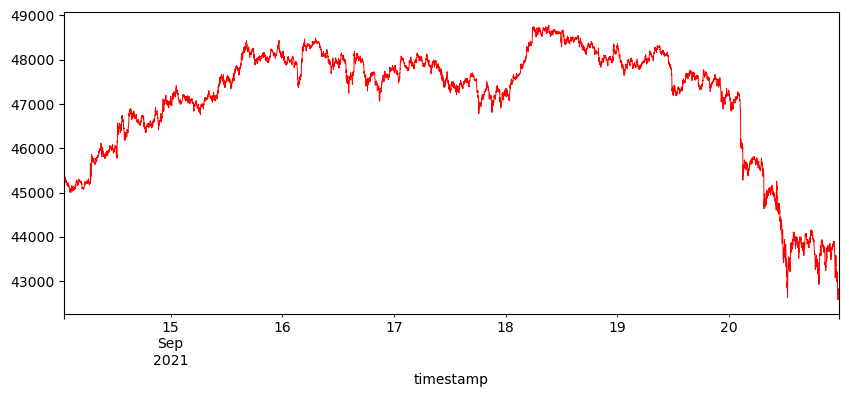

In [7]:
plt.rcParams.update({'figure.figsize':(10,4), 'figure.dpi':100})

data_raw.loc[data_1.index].Close.plot(linewidth=0.7, color='r')

plt.show()

In [7]:
X_train, X_test, Y_train, Y_test, Y_new_train, Y_new_test, Y_2_train, Y_2_test = train_test_split(X, Y, Y_new, Y_2, test_size=0.4, shuffle=False)
X_val, X_test, Y_val, Y_test, Y_new_val, Y_new_test, Y_2_val, Y_2_test = train_test_split(X_test, Y_test, Y_new_test, Y_2_test, test_size=0.5, shuffle=False)
print('All data size: %d' % X.size)
print('Train data size: %d' % X_train.size)
print('Validation data size: %d' % X_val.size)
print('Test data size: %d' % X_test.size)

All data size: 2020000
Train data size: 1212000
Validation data size: 404000
Test data size: 404000


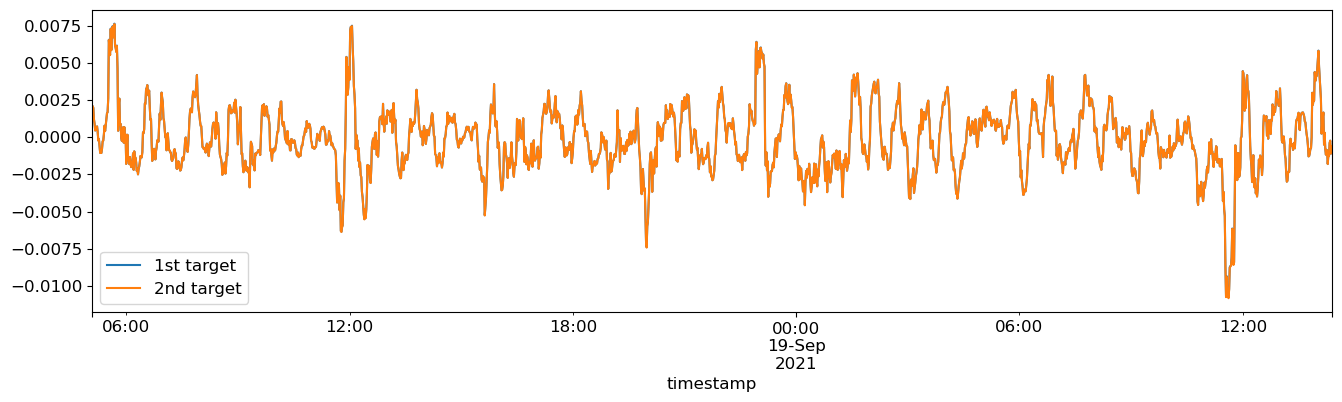

In [13]:
plt.rcParams.update({'figure.figsize':(16,4), 'figure.dpi':100, 'font.size':12})

data_1.Target.loc[X_val.index].plot(label='1st target')
data_1.Target_new.loc[X_val.index].plot(label='2nd target')

plt.legend()
plt.show()

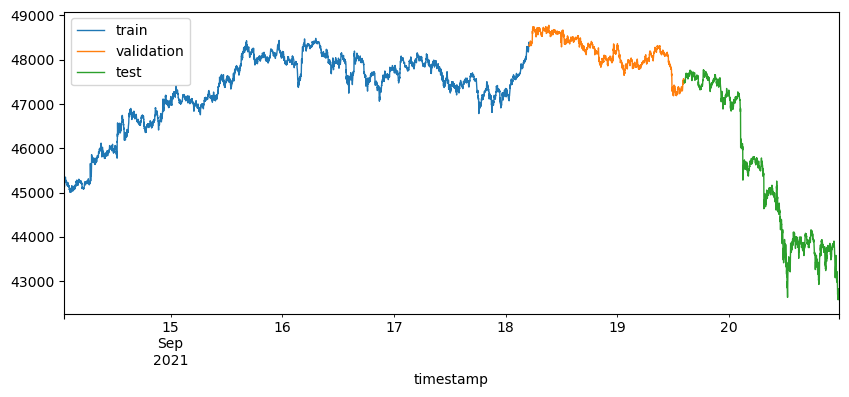

In [50]:
plt.rcParams.update({'figure.figsize':(10,4), 'figure.dpi':100})

data_raw['Close'].loc[X_train.index].plot(linewidth=1, label='train')
data_raw['Close'].loc[X_val.index].plot(linewidth=1, label='validation')
data_raw['Close'].loc[X_test.index].plot(linewidth=1, label='test')

plt.legend()
plt.show()

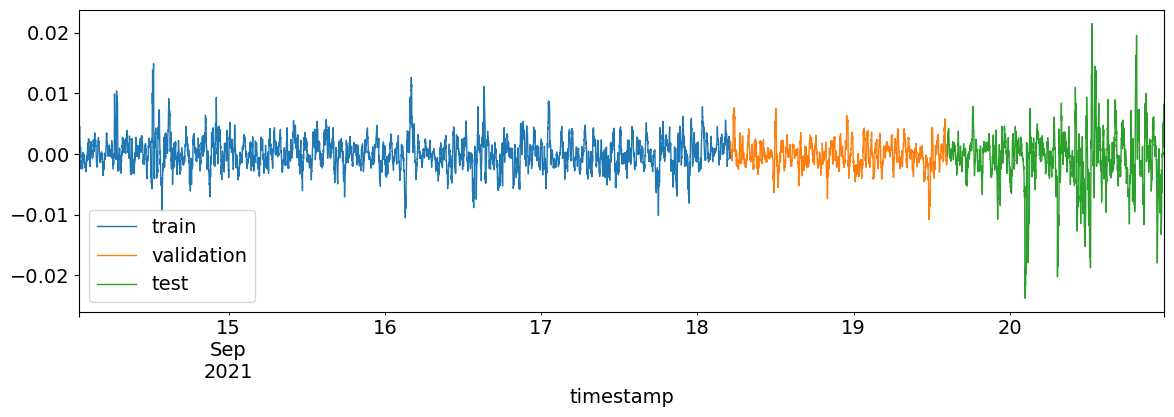

In [53]:
plt.rcParams.update({'figure.figsize':(14,4), 'figure.dpi':100, 'font.size':14})

data_1.Target.loc[X_train.index].plot(linewidth=1, label='train')
data_1.Target.loc[X_val.index].plot(linewidth=1, label='validation')
data_1.Target.loc[X_test.index].plot(linewidth=1, label='test')

plt.legend()
plt.show()

In [40]:
# X.to_csv('train_data/X.csv')
# Y.to_csv('train_data/Y.csv')
# Y_new.to_csv('train_data/Y_new.csv')
# X_train.to_csv('train_data/X_train.csv')
# X_val.to_csv('train_data/X_val.csv')
# X_test.to_csv('train_data/X_test.csv')
# Y_train.to_csv('train_data/Y_train.csv')
# Y_new_train.to_csv('train_data/Y_new_train.csv')
# Y_val.to_csv('train_data/Y_train.csv')
# Y_new_val.to_csv('train_data/Y_new_val.csv')
# Y_test.to_csv('train_data/Y_test.csv')
# Y_new_test.to_csv('train_data/Y_new_test.csv')

### Default model

In [20]:
X_test = X_val
Y_new_test = Y_new_val
Y_test = Y_val
Y_2_test = Y_2_val

In [21]:
start = time.time()
model_default = xgboost.XGBRegressor()
model_default.fit(X_train, Y_train)
model_default_time = time.time() - start

In [47]:
model_default.save_model('models/default2.json')

In [23]:
pred_train_default = model_default.predict(X_train)
pred_test_default = model_default.predict(X_test)

pred_train_series_default = pd.Series(pred_train_default, index=Y_train.index)
pred_test_series_default = pd.Series(pred_test_default, index=Y_test.index)

rmse_train_default = math.sqrt(mean_squared_error(Y_train, pred_train_default))
rmse_test_default = math.sqrt(mean_squared_error(Y_test, pred_test_default))

In [24]:
print('train rmse: ', rmse_train_default)
print('test rmse: ', rmse_test_default)

train rmse:  0.00042031667900888455
test rmse:  0.003460504030491677


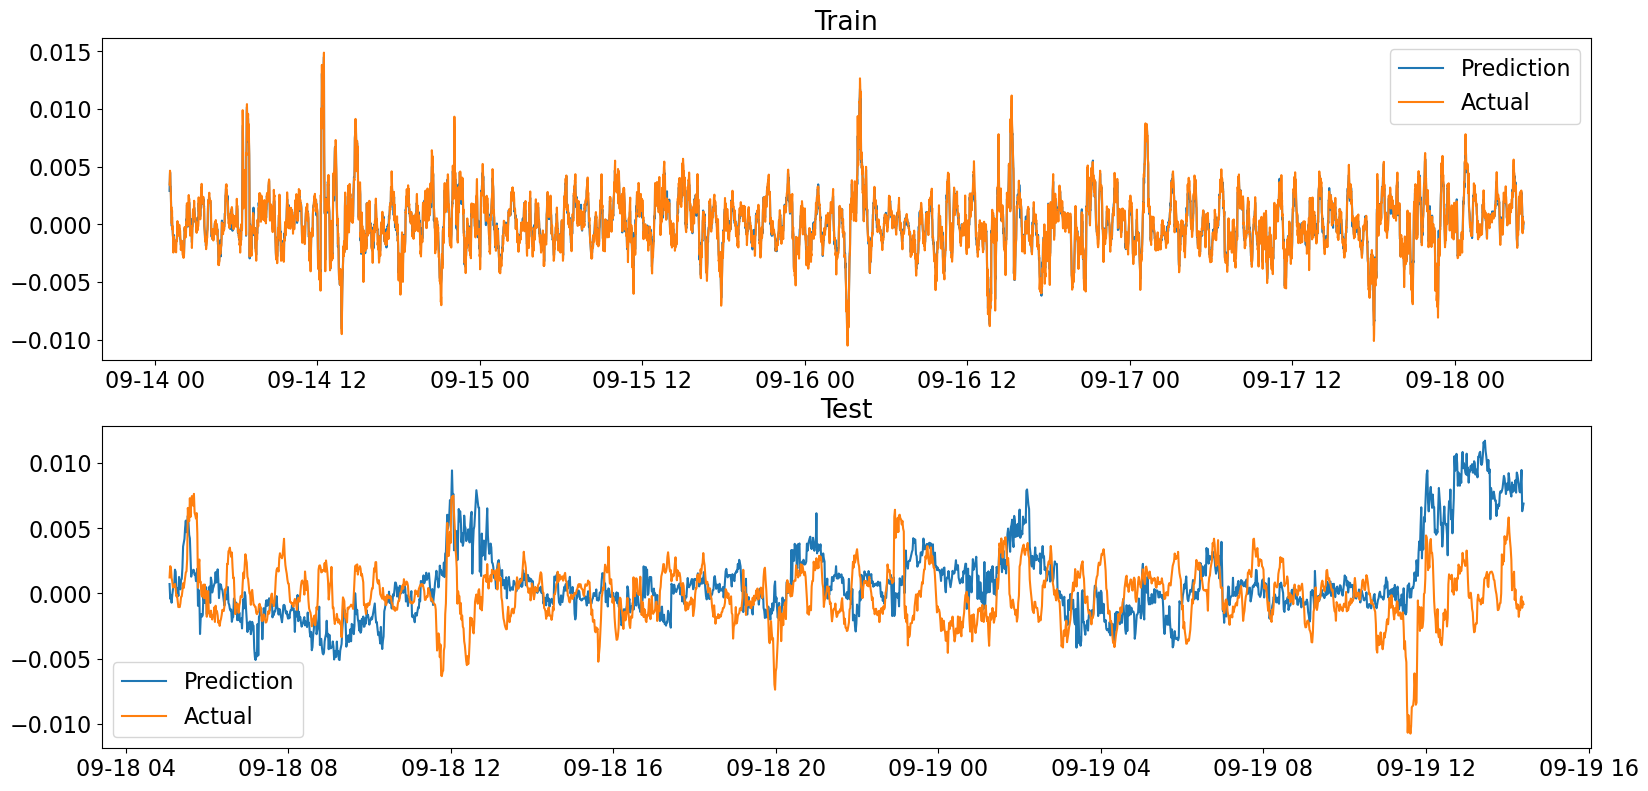

In [26]:
plt.rcParams.update({'figure.figsize':(16,8), 'figure.dpi':100, 'font.size': 16})

fig, axes = plt.subplots(2, 1)
fig.tight_layout()

axes[0].plot(pred_train_series_default, label = 'Prediction')
axes[0].plot(Y_train, label = 'Actual')
axes[0].set_title('Train')
axes[0].legend()

axes[1].plot(pred_test_series_default, label = 'Prediction')
axes[1].plot(Y_test, label = 'Actual')
axes[1].set_title('Test')
axes[1].legend()

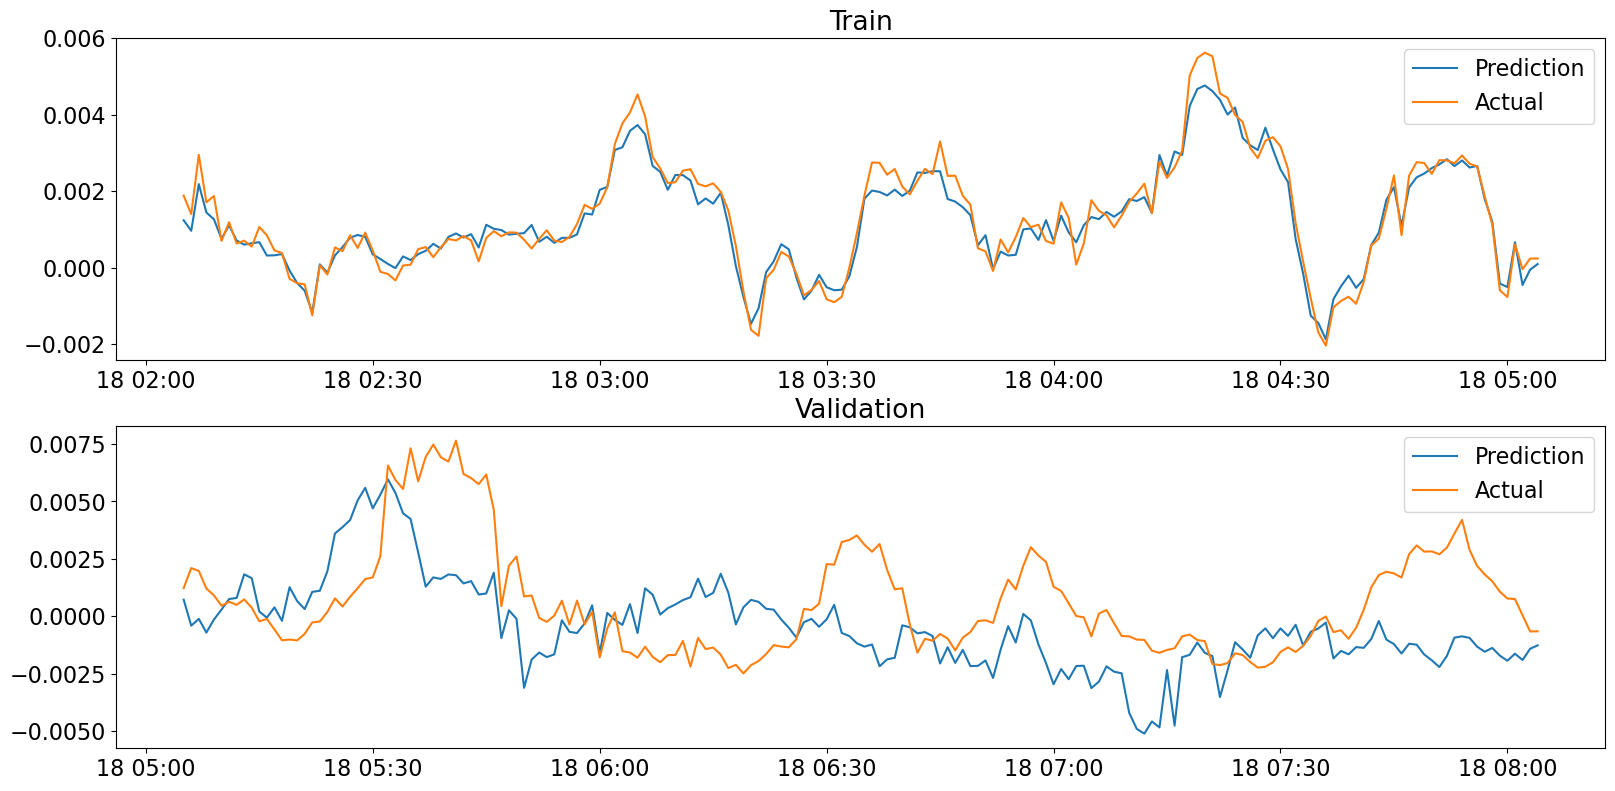

In [28]:
plt.rcParams.update({'figure.figsize':(16,8), 'figure.dpi':100})

fig, axes = plt.subplots(2, 1)
fig.tight_layout()

axes[0].plot(pred_train_series_default.tail(180), label = 'Prediction')
axes[0].plot(Y_train.tail(180), label = 'Actual')
axes[0].set_title('Train')
axes[0].legend()


axes[1].plot(pred_test_series_default.head(180), label = 'Prediction')
axes[1].plot(Y_test.head(180), label = 'Actual')
axes[1].set_title('Validation')
axes[1].legend()

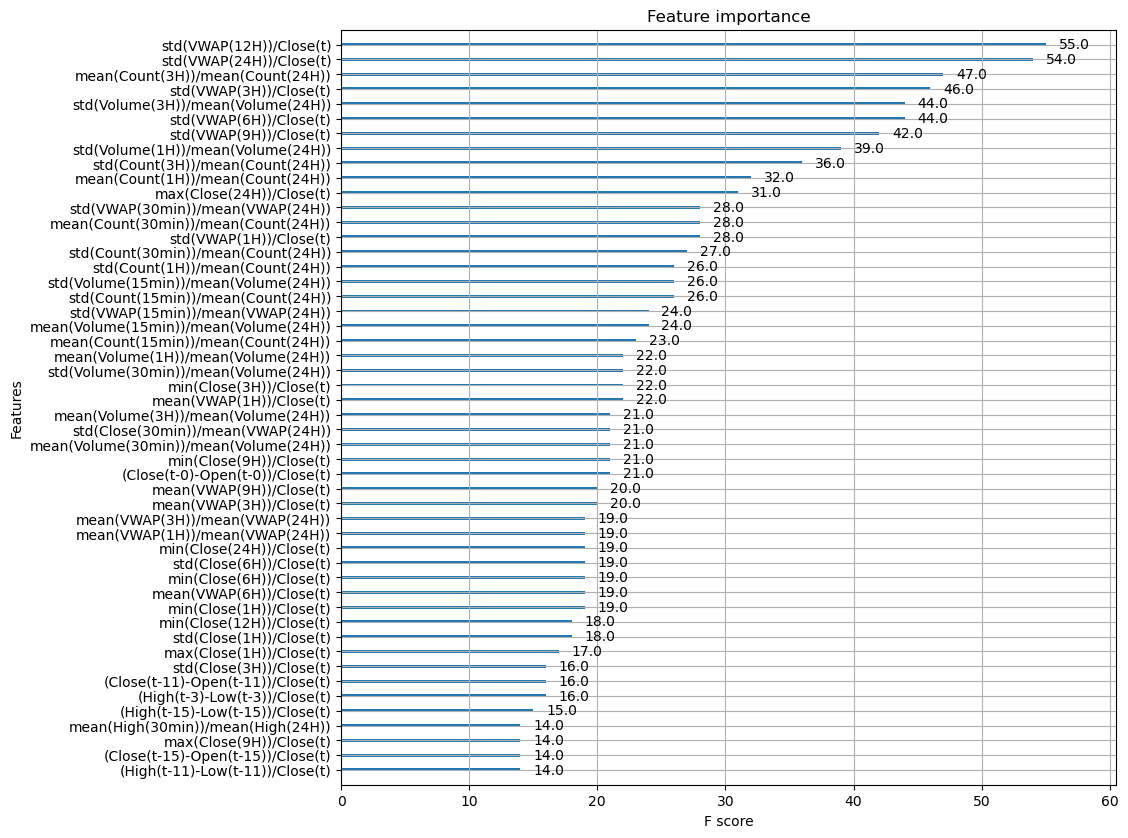

In [56]:
ax = xgboost.plot_importance(model_default, max_num_features=50)
fig = ax.figure
fig.set_size_inches(10, 10)

### XGBRegressor

In [8]:
reg = xgboost.XGBRegressor()

In [9]:
X_test = X_val
Y_new_test = Y_new_val
Y_test = Y_val
Y_2_test = Y_2_val

In [ ]:
plt.rcParams.update({'figure.figsize':(16,6), 'figure.dpi':100, 'lines.linewidth':0.7})

fig, axes = plt.subplots(2, 1)
fig.tight_layout()

axes[0].plot(Y_train, label = '1st residual target target')
axes[0].plot(Y_new_train, label = 'log target')
axes[0].plot(Y_2_train, label = '2nd residual target')
axes[0].set_title('Train')
axes[0].legend()


axes[1].plot(Y_test, label = '1st residual target target')
axes[1].plot(Y_new_test, label = 'log target')
axes[1].plot(Y_2_test, label = '2nd residual target')
axes[1].set_title('Test')
axes[1].legend()

### GridSearch eta n_estimators

In [19]:
eta_nest_params_new_huber = {
    'eta': [0.01, 0.03, 0.05, 0.07, 0.1, 0.3],
    'n_estimators': [100, 300, 500, 700, 900, 1000, 1100, 1300, 1500, 1700, 2000],
    'eval_metric': ['rmse'],
    'booster': ['gbtree'],
    'objective': ['reg:pseudohubererror']
}

In [54]:
# start = time.time()
# grid_model_log_huber_eta_nest = GridSearchCV(estimator=reg, param_grid=eta_nest_params_new_huber, scoring='neg_mean_squared_error')
# grid_model_log_huber_eta_nest.fit(X_train, Y_new_train)
# eta_nest_tuning_time_1 = time.time() - start

In [9]:
best_model_eta_nest_log_huber = xgboost.XGBRegressor()
best_model_eta_nest_log_huber.load_model('models/eta_nest_log_huber_2.json')

In [10]:
# best_model_eta_nest_log_huber = grid_model_log_huber_eta_nest.best_estimator_

In [11]:
best_params_eta_nest_log_huber = best_model_eta_nest_log_huber.get_params()
best_eta_huber = best_params_eta_nest_log_huber['eta']
best_nest_huber = best_params_eta_nest_log_huber['n_estimators']

In [12]:
print('Best eta: ', best_eta_huber)
print('Best n_estimators: ', best_nest_huber)

Best eta:  0.01
Best n_estimators:  700


In [30]:
model1 = xgboost.XGBRegressor(eta=best_eta_huber, n_estimators=best_nest_huber, eval_metric='rmse', booster='gbtree', objective='reg:pseudohubererror')
model1.fit(X_train, Y_new_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.01, eval_metric='rmse', gamma=0, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.00999999978, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=700, n_jobs=8, num_parallel_tree=1,
             objective='reg:pseudohubererror', predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, ...)

In [31]:
pred_train_1 = model1.predict(X_train)
pred_test_1 = model1.predict(X_test)

pred_train_series_1 = pd.Series(pred_train_1, index=Y_train.index)
pred_test_series_1 = pd.Series(pred_test_1, index=Y_new_test.index)

rmse_train_1 = math.sqrt(mean_squared_error(Y_new_train, pred_train_1))
rmse_test_1 = math.sqrt(mean_squared_error(Y_new_test, pred_test_1))

In [32]:
print('train rmse: ', rmse_train_1)
print('test rmse: ', rmse_test_1)

train rmse:  0.001441493033500607
test rmse:  0.0029752289820475825


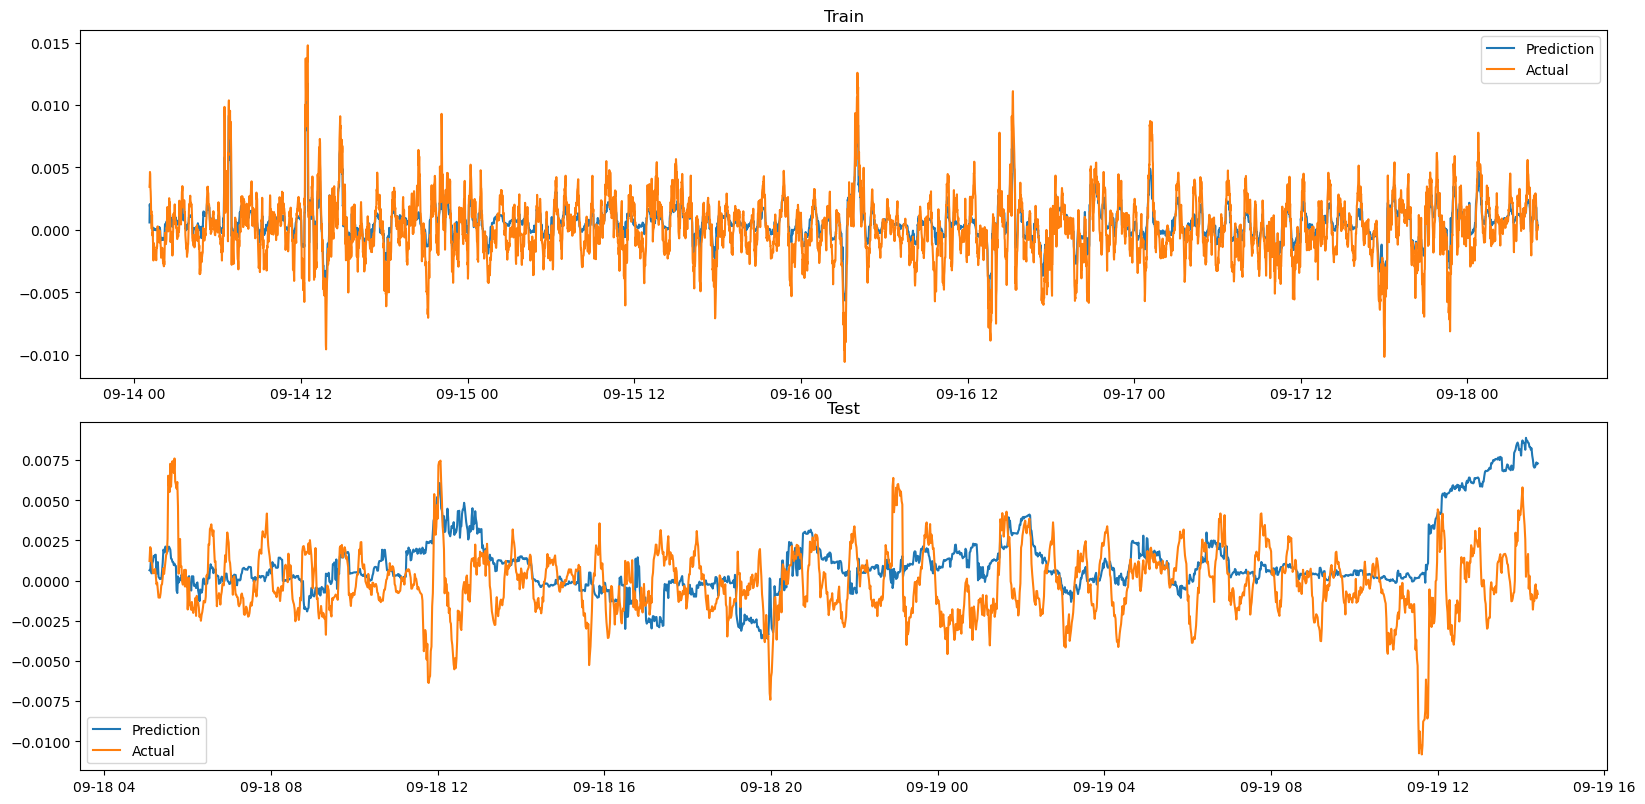

In [33]:
plt.rcParams.update({'figure.figsize':(16,8), 'figure.dpi':100})

fig, axes = plt.subplots(2, 1)
fig.tight_layout()

axes[0].plot(pred_train_series_1, label = 'Prediction')
axes[0].plot(Y_new_train, label = 'Actual')
axes[0].set_title('Train')
axes[0].legend()

axes[1].plot(pred_test_series_1, label = 'Prediction')
axes[1].plot(Y_new_test, label = 'Actual')
axes[1].set_title('Test')
axes[1].legend()

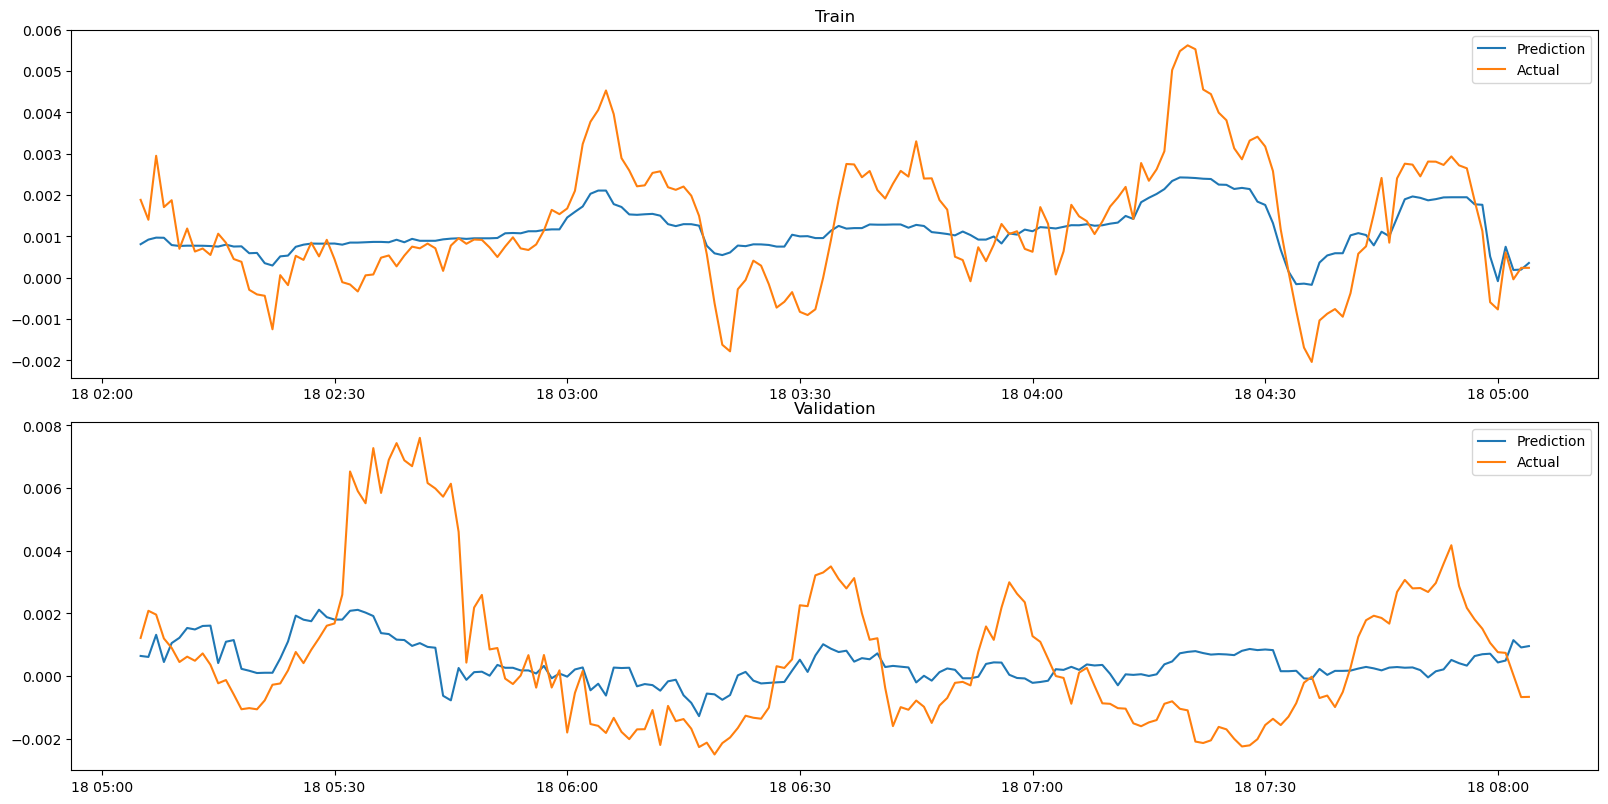

In [34]:
plt.rcParams.update({'figure.figsize':(16,8), 'figure.dpi':100})

fig, axes = plt.subplots(2, 1)
fig.tight_layout()

axes[0].plot(pred_train_series_1.tail(180), label = 'Prediction')
axes[0].plot(Y_train.tail(180), label = 'Actual')
axes[0].set_title('Train')
axes[0].legend()


axes[1].plot(pred_test_series_1.head(180), label = 'Prediction')
axes[1].plot(Y_new_test.head(180), label = 'Actual')
axes[1].set_title('Validation')
axes[1].legend()

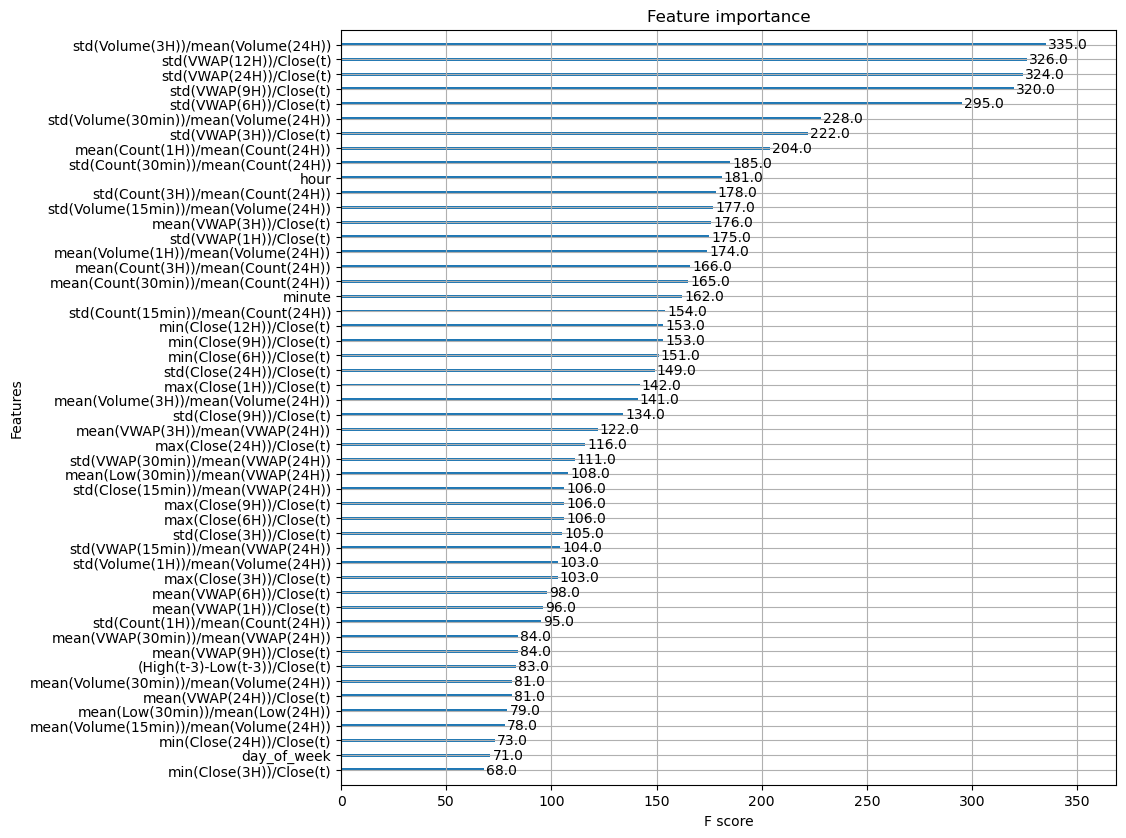

In [35]:
ax = xgboost.plot_importance(model1, max_num_features=50)
fig = ax.figure
fig.set_size_inches(10, 10)

In [36]:
# best_model_eta_nest_log_huber.save_model('models/eta_nest_log_huber_2.json')

### GridSearch eta n_estimators BlockingTimeSeriesSplit

In [29]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits

    def get_n_splits(self, X, y, groups):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

### eta n_estimators

In [49]:
# start = time.time()
# grid_model_log_huber_eta_nest_block = GridSearchCV(estimator=reg, param_grid=eta_nest_params_new_huber, cv=BlockingTimeSeriesSplit(n_splits=5).split(X_train), scoring='neg_mean_squared_error')
# grid_model_log_huber_eta_nest_block.fit(X_train, Y_new_train)
# eta_nest_tuning_time_2 = time.time() - start

TypeError: __init__() got an unexpected keyword argument 'n_iters'

In [44]:
# best_model_eta_nest_log_huber_block = grid_model_log_huber_eta_nest_block.best_estimator_

In [45]:
# best_model_eta_nest_log_huber_block.save_model('models/eta_nest_log_huber_block.json')

In [10]:
best_model_eta_nest_log_huber_block = xgboost.XGBRegressor()
best_model_eta_nest_log_huber_block.load_model('models/eta_nest_log_huber_block.json')

In [11]:
best_params_eta_nest_log_huber_block = best_model_eta_nest_log_huber_block.get_params()
best_eta_huber_block = best_params_eta_nest_log_huber_block['eta']
best_nest_huber_block = best_params_eta_nest_log_huber_block['n_estimators']

In [12]:
print('Best eta: ', best_eta_huber_block)
print('Best n_estimators: ', best_nest_huber_block)

Best eta:  0.1
Best n_estimators:  300


### lambda tuning

In [30]:
lambda_params_new_huber = {
    'eta': [best_eta_huber_block],
    'n_estimators': [best_nest_huber_block],
    'lambda': [1, 5, 10, 50, 100],
    'eval_metric': ['rmse'],
    'booster': ['gbtree'],
    'objective': ['reg:pseudohubererror']
}

In [31]:
start = time.time()
grid_model_log_huber_lambda_block = GridSearchCV(estimator=reg, param_grid=lambda_params_new_huber, cv=BlockingTimeSeriesSplit(n_splits=7).split(X_train), scoring='neg_mean_squared_error')
grid_model_log_huber_lambda_block.fit(X_train, Y_new_train)
eta_nest_tuning_time_3 = time.time() - start

In [32]:
print('Tuning time: ', datetime.timedelta(seconds=round(eta_nest_tuning_time_3)))

Tuning time:  0:01:04


In [34]:
best_model_lambda_log_huber_block = grid_model_log_huber_lambda_block.best_estimator_

In [35]:
best_model_lambda_log_huber_block.save_model('models/lambda_log_huber_block.json')

In [36]:
result_lambda_block = pd.DataFrame(grid_model_log_huber_lambda_block.cv_results_)
result_lambda_block.to_csv('cv_results/lambda_block.csv')

In [42]:
best_model_lambda_log_huber_block = xgboost.XGBRegressor()
best_model_lambda_log_huber_block.load_model('models/lambda_log_huber_block.json')

In [44]:
best_params_lambda_log_huber_block = best_model_lambda_log_huber_block.get_params()
best_lambda_huber_block = best_params_lambda_log_huber_block['lambda']

In [45]:
print('Best lambda: ', best_lambda_huber_block)

Best lambda:  1


### alpha tuning

In [46]:
alpha_params_new_huber = {
    'eta': [best_eta_huber_block],
    'n_estimators': [best_nest_huber_block],
    'lambda': [best_lambda_huber_block],
    'alpha': [0, 0.001, 0.005, 0.01, 0.05, 0.1],
    'eval_metric': ['rmse'],
    'booster': ['gbtree'],
    'objective': ['reg:pseudohubererror']
}

In [47]:
start = time.time()
grid_model_log_huber_alpha_block = GridSearchCV(estimator=reg, param_grid=alpha_params_new_huber, cv=BlockingTimeSeriesSplit(n_splits=7).split(X_train), scoring='neg_mean_squared_error')
grid_model_log_huber_alpha_block.fit(X_train, Y_new_train)
eta_nest_tuning_time_4 = time.time() - start

In [48]:
print('Tuning time: ', datetime.timedelta(seconds=round(eta_nest_tuning_time_4)))

Tuning time:  0:01:08


In [49]:
best_model_alpha_log_huber_block = grid_model_log_huber_alpha_block.best_estimator_

In [50]:
best_model_alpha_log_huber_block.save_model('models/alpha_log_huber_block.json')

In [51]:
result_alpha_block = pd.DataFrame(grid_model_log_huber_alpha_block.cv_results_)
result_alpha_block.to_csv('cv_results/alpha_block.csv')

In [52]:
best_model_alpha_log_huber_block = xgboost.XGBRegressor()
best_model_alpha_log_huber_block.load_model('models/alpha_log_huber_block.json')

In [53]:
best_params_alpha_log_huber_block = best_model_alpha_log_huber_block.get_params()
best_alpha_huber_block = best_params_alpha_log_huber_block['alpha']

In [54]:
print('Best alpha: ', best_alpha_huber_block)

Best alpha:  0


### gamma tuning

In [55]:
gamma_params_new_huber = {
    'eta': [best_eta_huber_block],
    'n_estimators': [best_nest_huber_block],
    'lambda': [best_lambda_huber_block],
    'alpha': [best_alpha_huber_block],
    'gamma': [0, 0.1],
    'eval_metric': ['rmse'],
    'booster': ['gbtree'],
    'objective': ['reg:pseudohubererror']
}

In [56]:
start = time.time()
grid_model_log_huber_gamma_block = GridSearchCV(estimator=reg, param_grid=gamma_params_new_huber, cv=BlockingTimeSeriesSplit(n_splits=7).split(X_train), scoring='neg_mean_squared_error')
grid_model_log_huber_gamma_block.fit(X_train, Y_new_train)
eta_nest_tuning_time_5 = time.time() - start

In [57]:
print('Tuning time: ', datetime.timedelta(seconds=round(eta_nest_tuning_time_5)))

Tuning time:  0:00:52


In [58]:
best_model_gamma_log_huber_block = grid_model_log_huber_gamma_block.best_estimator_

In [59]:
best_model_gamma_log_huber_block.save_model('models/gamma_log_huber_block.json')

In [60]:
result_gamma_block = pd.DataFrame(grid_model_log_huber_gamma_block.cv_results_)
result_gamma_block.to_csv('cv_results/gamma_block.csv')

In [61]:
best_model_gamma_log_huber_block = xgboost.XGBRegressor()
best_model_gamma_log_huber_block.load_model('models/gamma_log_huber_block.json')

In [62]:
best_params_gamma_log_huber_block = best_model_gamma_log_huber_block.get_params()
best_gamma_huber_block = best_params_gamma_log_huber_block['gamma']

In [63]:
print('Best gamma: ', best_gamma_huber_block)

Best gamma:  0.1


### model with best params

In [76]:
model2 = xgboost.XGBRegressor(
    eta=best_eta_huber_block,
    n_estimators=best_nest_huber_block,
    reg_lambda=best_lambda_huber_block,
    alpha=best_alpha_huber_block,
    gamma=best_gamma_huber_block,
    eval_metric='rmse',
    booster='gbtree',
    objective='reg:pseudohubererror'
)
model2.fit(X_train, Y_new_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.1, eval_metric='rmse', gamma=0.1, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=8, num_parallel_tree=1,
             objective='reg:pseudohubererror', predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, ...)

In [77]:
pred_train_2 = model2.predict(X_train)
pred_test_2 = model2.predict(X_test)

pred_train_series_2 = pd.Series(pred_train_2, index=Y_new_train.index)
pred_test_series_2 = pd.Series(pred_test_2, index=Y_new_test.index)

rmse_train_2 = math.sqrt(mean_squared_error(Y_new_train, pred_train_2))
rmse_test_2 = math.sqrt(mean_squared_error(Y_new_test, pred_test_2))

In [78]:
print('train rmse: ', rmse_train_2)
print('test rmse: ', rmse_test_2)

train rmse:  0.0024625709081206363
test rmse:  0.0021611574438326554


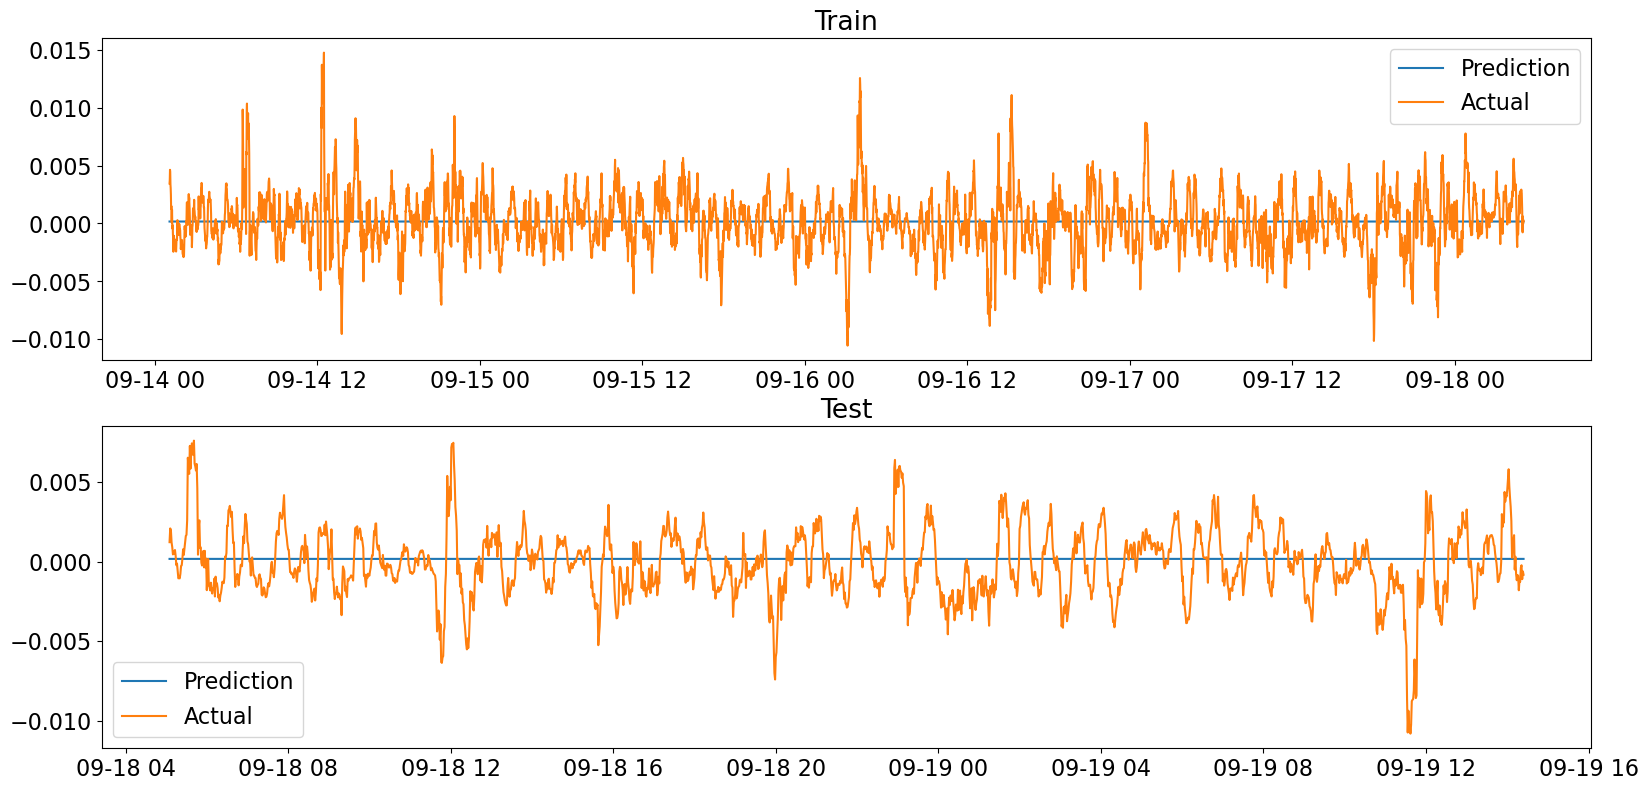

In [79]:
plt.rcParams.update({'figure.figsize': (16, 8), 'figure.dpi': 100, 'font.size':16})

fig, axes = plt.subplots(2, 1)
fig.tight_layout()

axes[0].plot(pred_train_series_2, label='Prediction')
axes[0].plot(Y_new_train, label='Actual')
axes[0].set_title('Train')
axes[0].legend()

axes[1].plot(pred_test_series_2, label='Prediction')
axes[1].plot(Y_new_test, label='Actual')
axes[1].set_title('Test')
axes[1].legend()

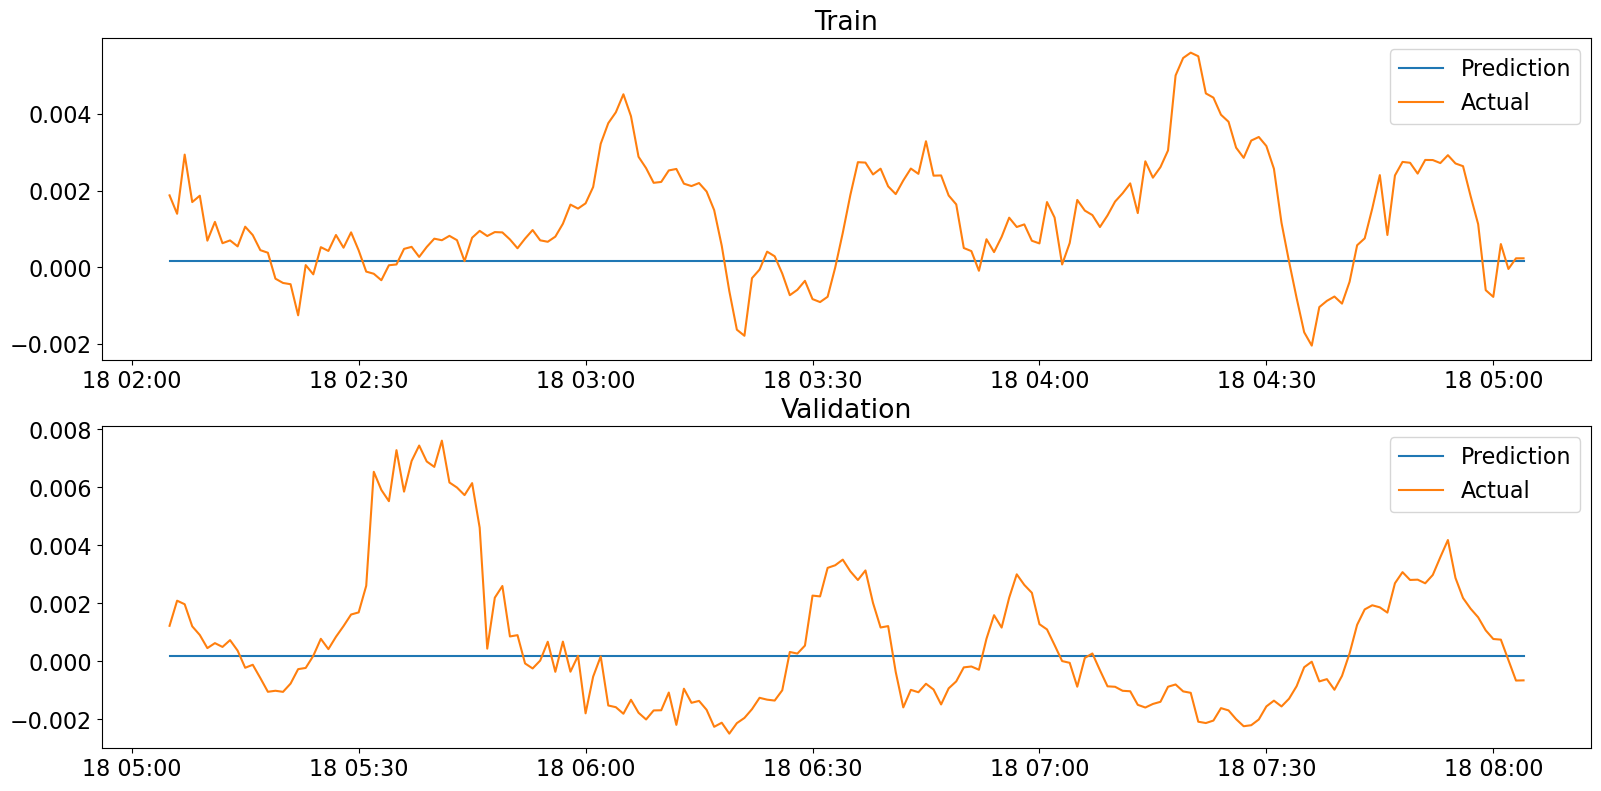

In [80]:
plt.rcParams.update({'figure.figsize': (16, 8), 'figure.dpi': 100, 'font.size':16})

fig, axes = plt.subplots(2, 1)
fig.tight_layout()

axes[0].plot(pred_train_series_2.tail(180), label='Prediction')
axes[0].plot(Y_new_train.tail(180), label='Actual')
axes[0].set_title('Train')
axes[0].legend()

axes[1].plot(pred_test_series_2.head(180), label='Prediction')
axes[1].plot(Y_new_test.head(180), label='Actual')
axes[1].set_title('Validation')
axes[1].legend()

In [81]:
plt.rcParams.update({'figure.dpi': 100, 'font.size':10})

ax = xgboost.plot_importance(model2, max_num_features=50)
fig = ax.figure
fig.set_size_inches(10, 10)

ValueError: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.

### GridSearch eta n_estimators BlockingTimeSeriesSplit Target_2

In [26]:
# start = time.time()
# grid_model_log_huber_eta_nest_block2 = GridSearchCV(estimator=reg, param_grid=eta_nest_params_new_huber, cv=BlockingTimeSeriesSplit(n_splits=5).split(X_train), scoring='neg_mean_squared_error')
# grid_model_log_huber_eta_nest_block2.fit(X_train, Y_2_train)
# eta_nest_tuning_time_3 = time.time() - start

In [31]:
# print('Execution time: ', datetime.timedelta(seconds=round(eta_nest_tuning_time_3)))

Execution time:  0:26:14


In [27]:
# best_model_eta_nest_log_huber_block2 = grid_model_log_huber_eta_nest_block2.best_estimator_

In [28]:
# best_model_eta_nest_log_huber_block2.save_model('models/eta_nest_log_huber_block2.json')

In [11]:
best_model_eta_nest_log_huber_block2 = xgboost.XGBRegressor()
best_model_eta_nest_log_huber_block2.load_model('models/eta_nest_log_huber_block2.json')

In [12]:
best_params_eta_nest_log_huber_block2 = best_model_eta_nest_log_huber_block2.get_params()
best_eta_huber_block2 = best_params_eta_nest_log_huber_block2['eta']
best_nest_huber_block2 = best_params_eta_nest_log_huber_block2['n_estimators']

In [13]:
print('Best eta: ', best_eta_huber_block2)
print('Best n_estimators: ', best_nest_huber_block2)

Best eta:  0.05
Best n_estimators:  500


In [14]:
model3 = xgboost.XGBRegressor(eta=best_eta_huber_block2, n_estimators=best_nest_huber_block2, eval_metric='rmse',
                              booster='gbtree',
                              objective='reg:pseudohubererror')
model3.fit(X_train, Y_2_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.05, eval_metric='rmse', gamma=0, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.0500000007, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=8, num_parallel_tree=1,
             objective='reg:pseudohubererror', predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, ...)

In [15]:
pred_train_3 = model3.predict(X_train)
pred_test_3 = model3.predict(X_test)

pred_train_series_3 = pd.Series(pred_train_3, index=Y_2_train.index)
pred_test_series_3 = pd.Series(pred_test_3, index=Y_2_test.index)

rmse_train_3 = math.sqrt(mean_squared_error(Y_2_train, pred_train_3))
rmse_test_3 = math.sqrt(mean_squared_error(Y_2_test, pred_test_3))

In [16]:
print('train rmse: ', rmse_train_3)
print('test rmse: ', rmse_test_3)

train rmse:  0.00046930915013460776
test rmse:  0.003192296147611799


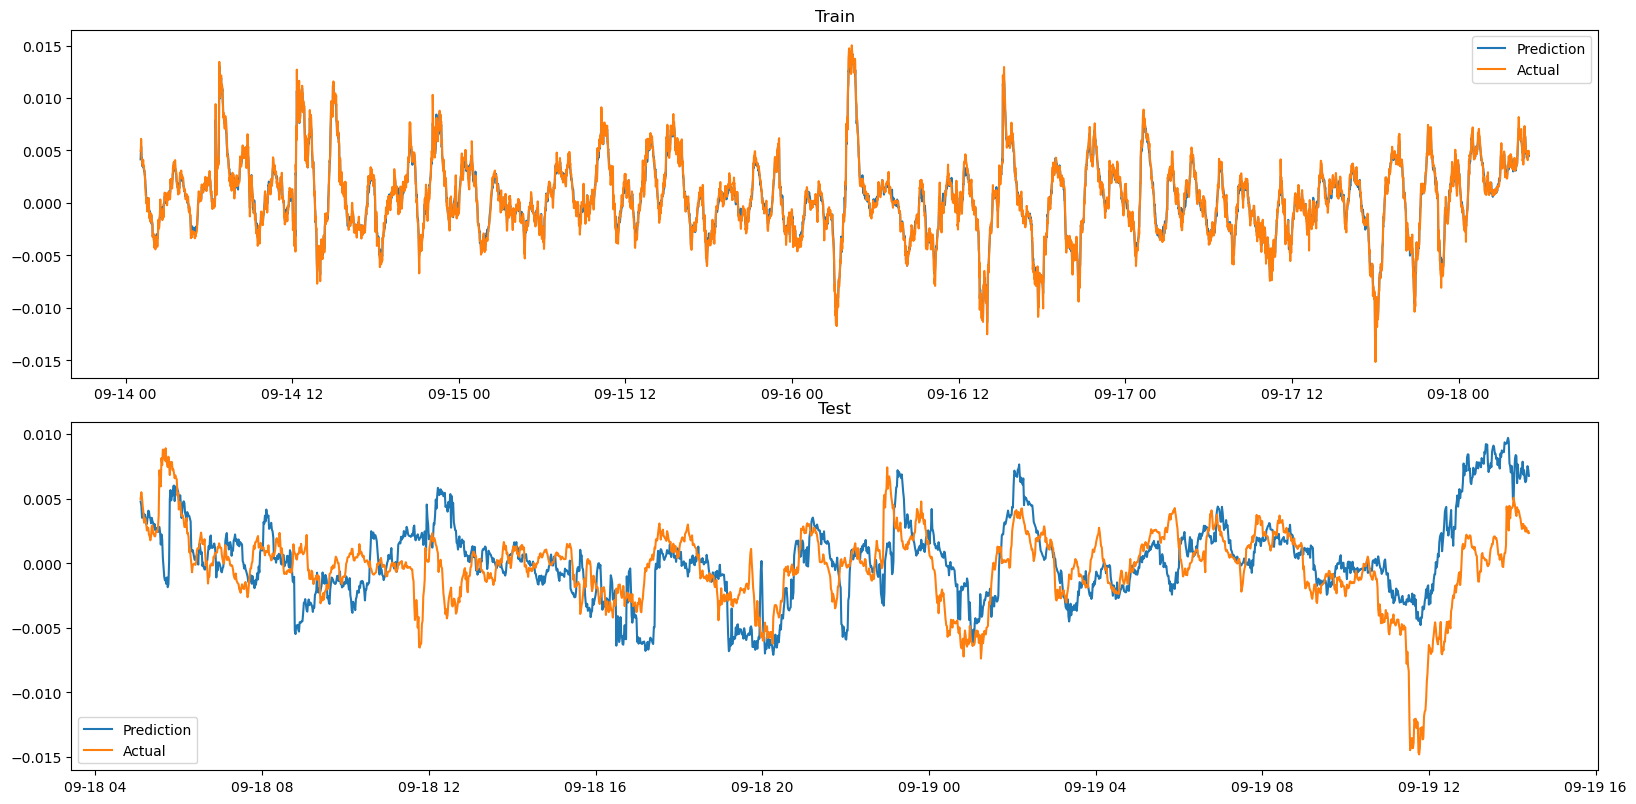

In [17]:
plt.rcParams.update({'figure.figsize': (16, 8), 'figure.dpi': 100})

fig, axes = plt.subplots(2, 1)
fig.tight_layout()

axes[0].plot(pred_train_series_3, label='Prediction')
axes[0].plot(Y_2_train, label='Actual')
axes[0].set_title('Train')
axes[0].legend()

axes[1].plot(pred_test_series_3, label='Prediction')
axes[1].plot(Y_2_test, label='Actual')
axes[1].set_title('Test')
axes[1].legend()

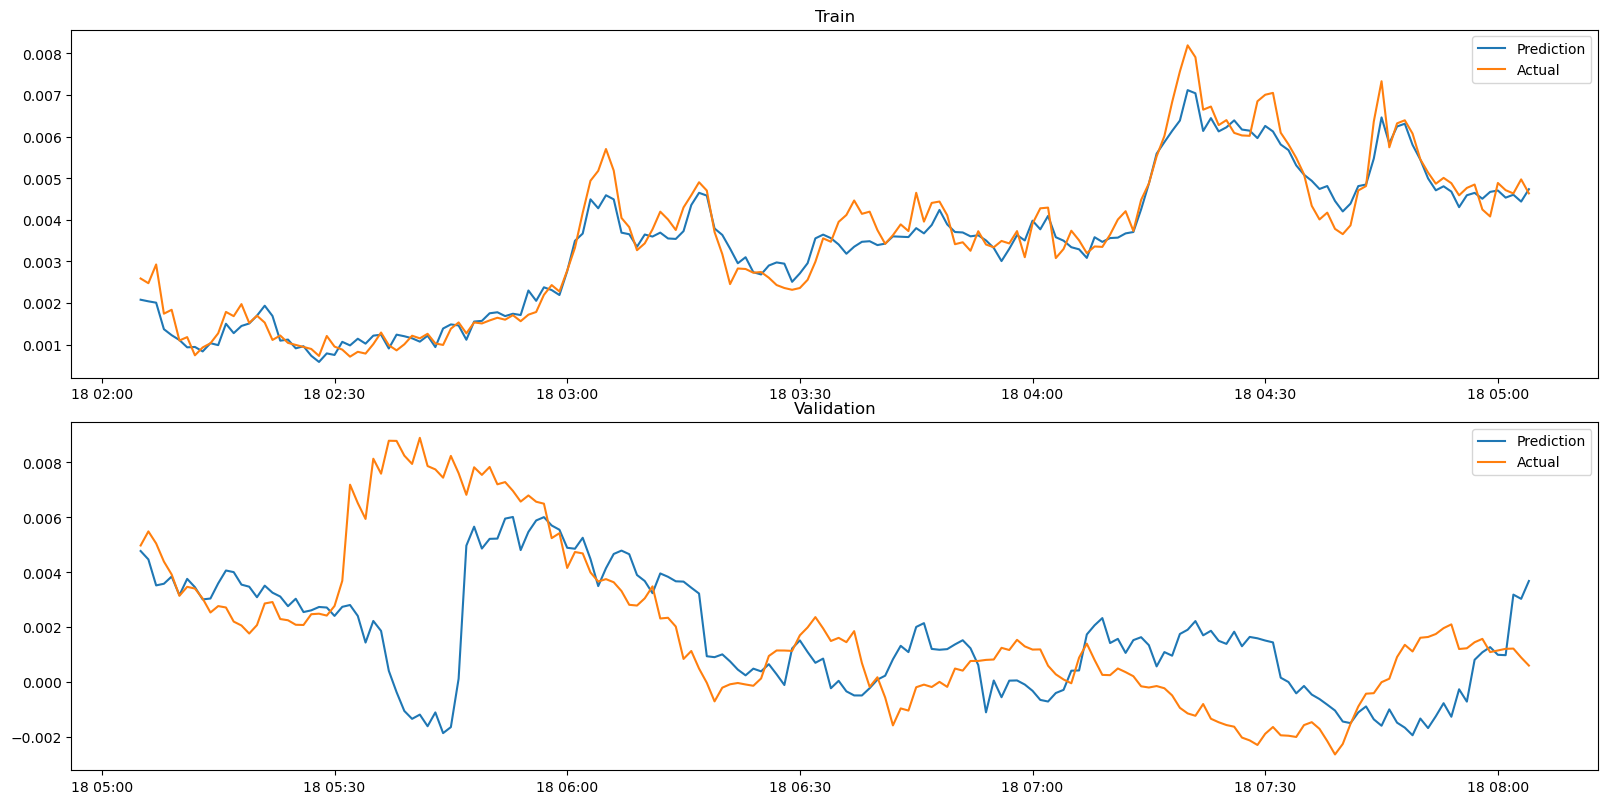

In [18]:
plt.rcParams.update({'figure.figsize': (16, 8), 'figure.dpi': 100})

fig, axes = plt.subplots(2, 1)
fig.tight_layout()

axes[0].plot(pred_train_series_3.tail(180), label='Prediction')
axes[0].plot(Y_2_train.tail(180), label='Actual')
axes[0].set_title('Train')
axes[0].legend()

axes[1].plot(pred_test_series_3.head(180), label='Prediction')
axes[1].plot(Y_2_test.head(180), label='Actual')
axes[1].set_title('Validation')
axes[1].legend()

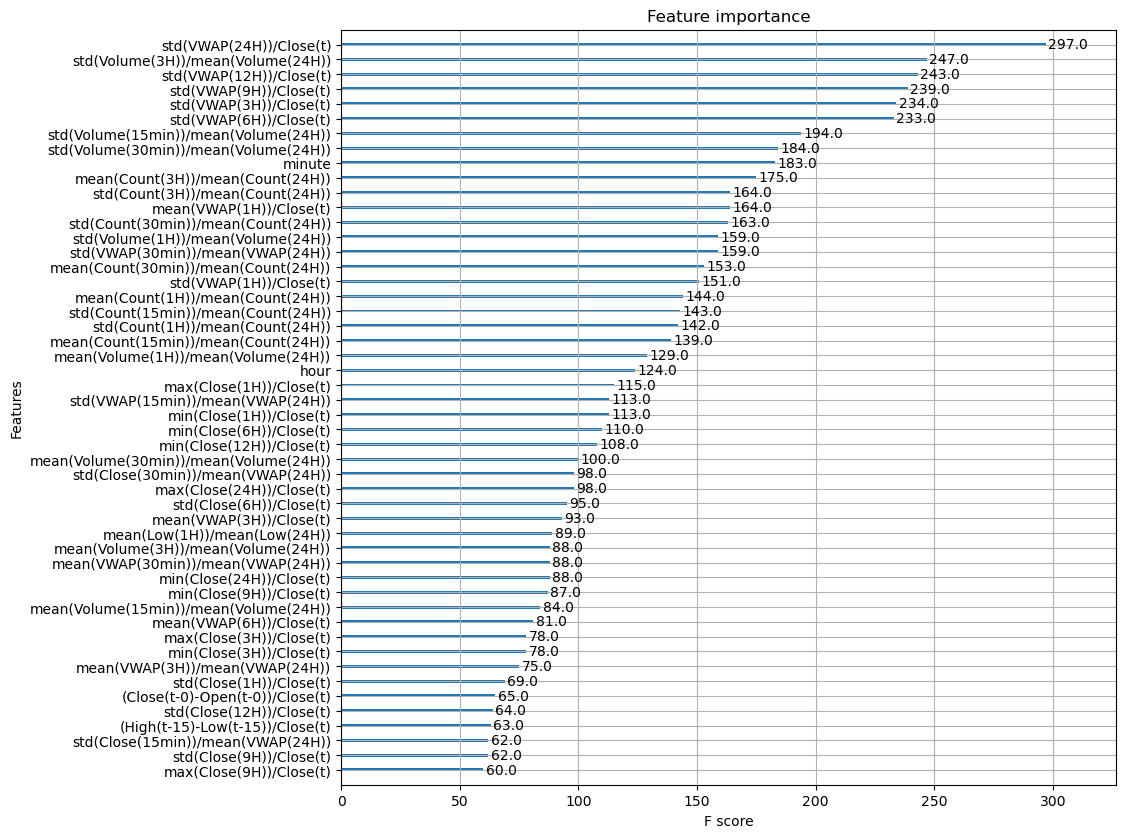

In [19]:
ax = xgboost.plot_importance(model3, max_num_features=50)
fig = ax.figure
fig.set_size_inches(10, 10)

In [34]:
pred_series2 = pd.concat([pred_train_series_3, pred_test_series_3])
close_series2 = data_raw.Close.loc[pred_series2.index]
target_series2 = data_1.Target_2.loc[pred_series2.index]

In [35]:
pred_test_series_3

timestamp
2021-09-18 05:05:00    0.004771
2021-09-18 05:06:00    0.004465
2021-09-18 05:07:00    0.003519
2021-09-18 05:08:00    0.003579
2021-09-18 05:09:00    0.003843
                         ...   
2021-09-19 14:20:00    0.006373
2021-09-19 14:21:00    0.006981
2021-09-19 14:22:00    0.007507
2021-09-19 14:23:00    0.007262
2021-09-19 14:24:00    0.006756
Length: 2000, dtype: float32

In [36]:
table2 = pd.DataFrame(
    {'initial target': target_series2, 'predicted target': pred_series2, 'actual close': close_series2})
table2

,initial target,predicted target,actual close
timestamp,,,
2021-09-14 01:05:00,0.004974,0.004158,45135.727143
2021-09-14 01:06:00,0.005087,0.004961,45129.775714
2021-09-14 01:07:00,0.006106,0.005412,45138.098571
2021-09-14 01:08:00,0.005695,0.005196,45131.365714
2021-09-14 01:09:00,0.004365,0.004261,45124.667143
...,...,...,...
2021-09-19 14:20:00,0.002756,0.006373,47517.457941
2021-09-19 14:21:00,0.002589,0.006981,47504.806250
2021-09-19 14:22:00,0.002371,0.007507,47539.463750


In [37]:
table2['Close(t+15)'] = (table2['initial target'] + 1) * table2['actual close'].rolling('1H').mean()
table2['predicted Close(t+15)'] = (table2['predicted target'] + 1) * table2['actual close'].rolling('1H').mean()

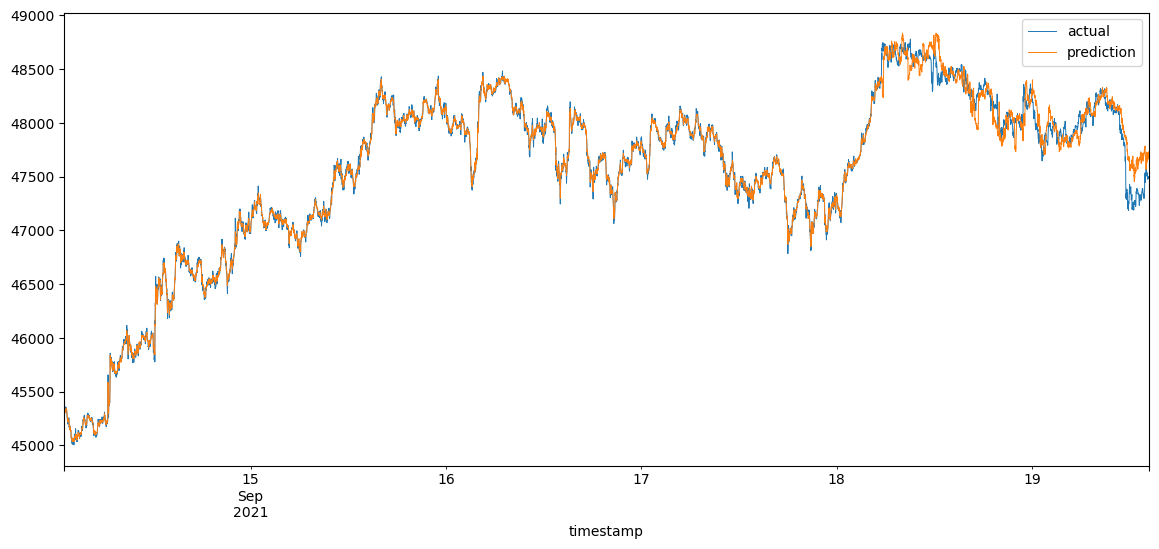

In [40]:
plt.rcParams.update({'figure.figsize': (14, 6), 'figure.dpi': 100, 'lines.linewidth': 0.7})

table2['Close(t+15)'].plot(label='actual')
table2['predicted Close(t+15)'].plot(label='prediction')

plt.legend()
plt.show()

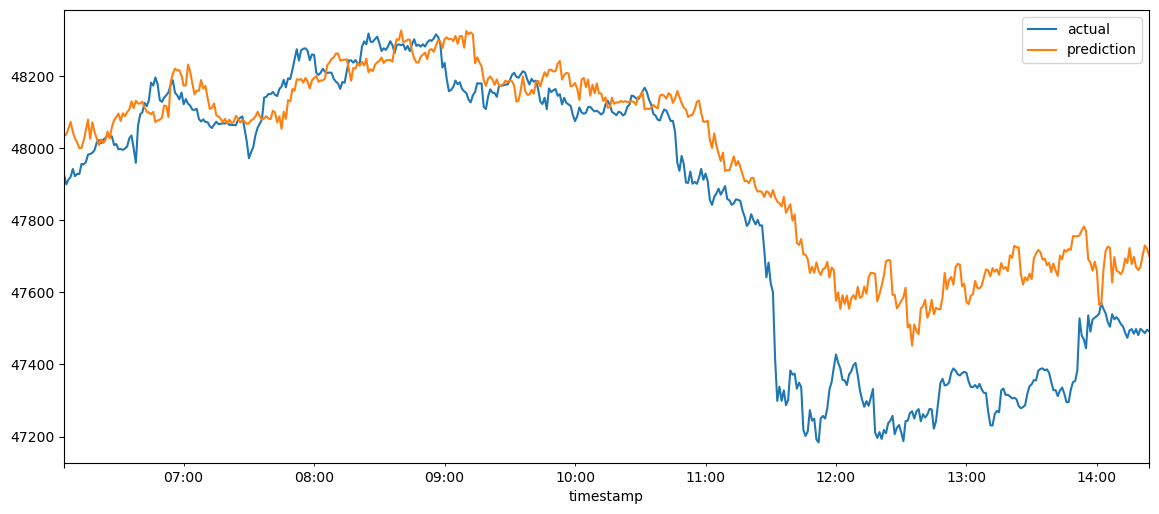

In [39]:
plt.rcParams.update({'figure.figsize':(14,6), 'figure.dpi':100})

table2['Close(t+15)'].tail(500).plot(label='actual')
table2['predicted Close(t+15)'].tail(500).plot(label='prediction')

plt.legend()
plt.show()